<a href="https://colab.research.google.com/github/giangdip2410/Colab-Notebook/blob/main/Hypernetwork_ResNet18_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Library
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
import argparse
import torch.optim as optim
try:
  from pytorch_model_summary import summary
except:
  !pip install pytorch-model-summary -q
  from pytorch_model_summary import summary
from torch.nn.parameter import Parameter
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as data
import copy
import random
import time
from tqdm.notebook import trange, tqdm
from sklearn import metrics

### Config

In [2]:
#config

learning_rate = 0.002
criterion = nn.CrossEntropyLoss()

epochs = 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 42
batch_size = 128
num_workers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_name = 'hyper_resnet'

In [3]:
#fix seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Dataloader

In [4]:
########### Data Loader ###############
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_data  = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_train)

# train valid split - valid ratio 
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
#train val split
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])
test_data  = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_test)
# dataloader
train_iterator  = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

valid_iterator  = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                          shuffle=False, num_workers=num_workers)
test_iterator  = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

100%|██████████| 170498071/170498071 [00:03<00:00, 47396303.87it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [5]:
#plot image 
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].cpu().numpy(), cmap='bone')
        ax.axis('off')

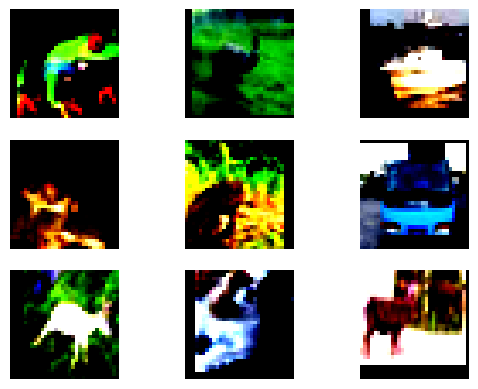

In [6]:
#sample plot
N_IMAGES = 9

images = [image.permute(1, 2, 0) for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

### Model

In [7]:
class HyperNetwork(nn.Module):

    def __init__(self, f_size = 3, z_dim = 64, out_size=16, in_size=16, device=None):
        super(HyperNetwork, self).__init__()
        self.z_dim = z_dim
        self.f_size = f_size
        self.out_size = out_size
        self.in_size = in_size

        self.w1 = Parameter(torch.fmod(torch.randn((self.z_dim, self.out_size*self.f_size*self.f_size)).to(device),2))
        self.b1 = Parameter(torch.fmod(torch.randn((self.out_size*self.f_size*self.f_size)).to(device),2))

        self.w2 = Parameter(torch.fmod(torch.randn((self.z_dim, self.in_size*self.z_dim)).to(device),2))
        self.b2 = Parameter(torch.fmod(torch.randn((self.in_size*self.z_dim)).to(device),2))

    def forward(self, z):

        h_in = torch.matmul(z, self.w2) + self.b2
        h_in = h_in.view(self.in_size, self.z_dim)

        h_final = torch.matmul(h_in, self.w1) + self.b1
        kernel = h_final.view(self.out_size, self.in_size, self.f_size, self.f_size)

        return kernel

In [8]:
# resnet block
class IdentityLayer(nn.Module):

    def forward(self, x):
        return x


class ResNetBlock(nn.Module):

    def __init__(self, in_size=16, out_size=16, downsample = False):
        super(ResNetBlock,self).__init__()
        self.out_size = out_size
        self.in_size = in_size
        if downsample:
            self.stride1 = 2
            self.reslayer = nn.Conv2d(in_channels=self.in_size, out_channels=self.out_size, stride=2, kernel_size=1)
        else:
            self.stride1 = 1
            self.reslayer = IdentityLayer()

        self.bn1 = nn.BatchNorm2d(out_size)
        self.bn2 = nn.BatchNorm2d(out_size)

    def forward(self, x, conv1_w, conv2_w):

        residual = self.reslayer(x)

        out = F.relu(self.bn1(F.conv2d(x, conv1_w, stride=self.stride1, padding=1)), inplace=True)
        out = self.bn2(F.conv2d(out, conv2_w, padding=1))

        out += residual

        out = F.relu(out)

        return out

In [9]:
# embedding
class Embedding(nn.Module):

    def __init__(self, z_num, z_dim, device):
        super(Embedding, self).__init__()

        self.z_list = nn.ParameterList()
        self.z_num = z_num
        self.z_dim = z_dim

        h,k = self.z_num

        for i in range(h):
            for j in range(k):
                self.z_list.append(Parameter(torch.fmod(torch.randn(self.z_dim).to(device), 2)))

    def forward(self, hyper_net):
        ww = []
        h, k = self.z_num
        for i in range(h):
            w = []
            for j in range(k):
                w.append(hyper_net(self.z_list[i*k + j]))
            ww.append(torch.cat(w, dim=1))
        return torch.cat(ww, dim=0)

In [10]:

class PrimaryNetwork(nn.Module):

    def __init__(self, z_dim=64, device=None):
        super(PrimaryNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.z_dim = z_dim
        self.hope = HyperNetwork(z_dim=self.z_dim, device=device)

        self.zs_size = [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1],
                        [2, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2],
                        [4, 2], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4]]

        self.filter_size = [[16,16], [16,16], [16,16], [16,16], [16,16], [16,16], [16,32], [32,32], [32,32], [32,32],
                            [32,32], [32,32], [32,64], [64,64], [64,64], [64,64], [64,64], [64,64]]

        self.res_net = nn.ModuleList()

        for i in range(18):
            down_sample = False
            if i > 5 and i % 6 == 0:
                down_sample = True
            self.res_net.append(ResNetBlock(self.filter_size[i][0], self.filter_size[i][1], downsample=down_sample))

        self.zs = nn.ModuleList()

        for i in range(36):
            self.zs.append(Embedding(self.zs_size[i], self.z_dim, device=device))

        self.global_avg = nn.AvgPool2d(8)
        self.final = nn.Linear(64,10)

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))

        for i in range(18):
            # if i != 15 and i != 17:
            w1 = self.zs[2*i](self.hope)
            w2 = self.zs[2*i+1](self.hope)
            x = self.res_net[i](x, w1, w2)

        x = self.global_avg(x)
        x = self.final(x.view(-1,64))

        return x

### Create Model

In [11]:
############ model

model = PrimaryNetwork(device=device)
model

PrimaryNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hope): HyperNetwork()
  (res_net): ModuleList(
    (0-5): 6 x ResNetBlock(
      (reslayer): IdentityLayer()
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (6): ResNetBlock(
      (reslayer): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (7-11): 5 x ResNetBlock(
      (reslayer): IdentityLayer()
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_runn

### Traning function

In [12]:
#metric to calculate model performance
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
#calculate timing
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
#training step function
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
#validate step function
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Start Training

In [20]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
#move to CPU
model = model.to(device)
criterion = criterion.to(device)

In [21]:
# start training

best_valid_loss = float('inf')

for epoch in trange(epochs):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'{save_name}.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
     

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 43s
	Train Loss: 1.812 | Train Acc: 31.44%
	 Val. Loss: 1.706 |  Val. Acc: 37.46%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 44s
	Train Loss: 1.468 | Train Acc: 45.53%
	 Val. Loss: 1.439 |  Val. Acc: 47.07%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 45s
	Train Loss: 1.302 | Train Acc: 52.34%
	 Val. Loss: 1.336 |  Val. Acc: 50.92%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 44s
	Train Loss: 1.172 | Train Acc: 57.49%
	 Val. Loss: 1.214 |  Val. Acc: 56.07%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 45s
	Train Loss: 1.088 | Train Acc: 60.74%
	 Val. Loss: 1.079 |  Val. Acc: 60.94%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 43s
	Train Loss: 1.015 | Train Acc: 63.54%
	 Val. Loss: 0.997 |  Val. Acc: 63.34%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 44s
	Train Loss: 0.958 | Train Acc: 65.45%
	 Val. Loss: 0.922 |  Val. Acc: 66.66%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 43s
	Train Loss: 0.913 | Train Acc: 67.32%
	 Val. Loss: 0.921 |  Val. Acc: 67.29%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 43s
	Train Loss: 0.878 | Train Acc: 68.69%
	 Val. Loss: 1.061 |  Val. Acc: 63.93%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 43s
	Train Loss: 0.839 | Train Acc: 70.11%
	 Val. Loss: 0.874 |  Val. Acc: 69.08%


In [23]:
#load model print model accuracy
model.load_state_dict(torch.load(f'{save_name}.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.868 | Test Acc: 69.10%


### Diagnostics Model

In [26]:
#prediction function
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [27]:
#plot confusion matrix

def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

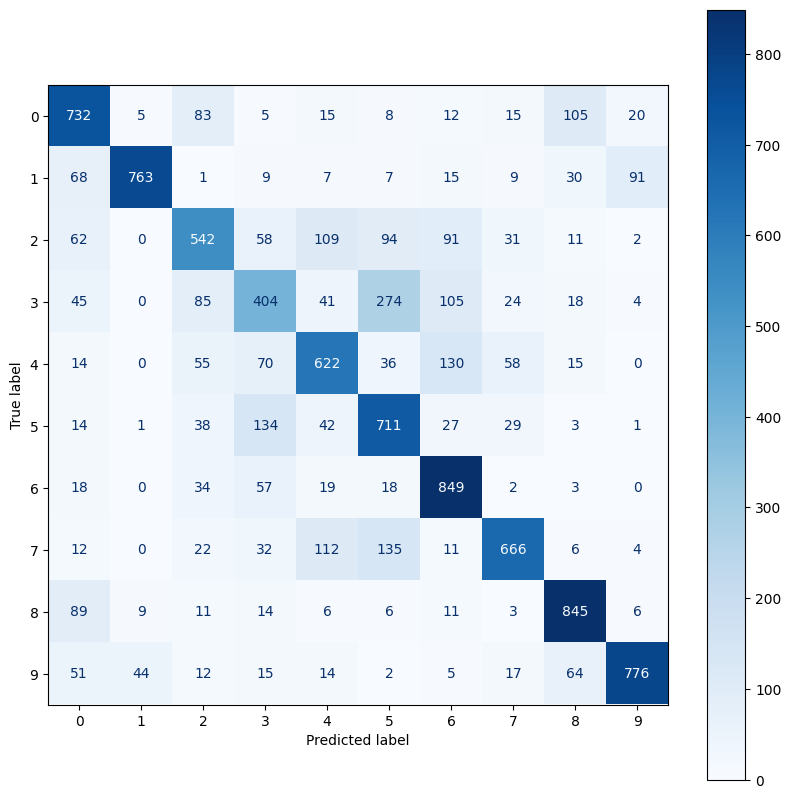

In [28]:
diagnostics  = True
if diagnostics:
  #get predict for test set
  images, labels, probs = get_predictions(model, test_iterator, device)

  pred_labels = torch.argmax(probs, 1)
  #show plot
  plot_confusion_matrix(labels, pred_labels)